In [2]:
from glob import glob
import os
from tqdm import tqdm
import numpy as np
import seaborn as sns
from collections import Counter
import SimpleITK as sitk
from radiomics import featureextractor as fe
import pandas as pd
import numpy as np
import nibabel as nib
from copy import deepcopy
import matplotlib.pyplot as plt

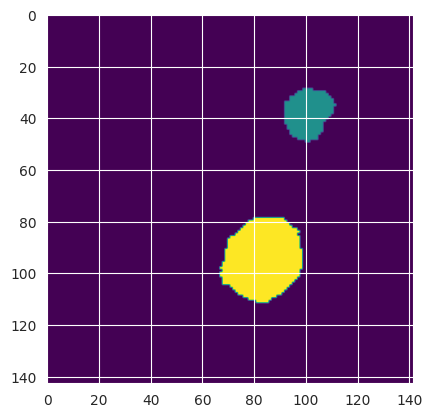

In [3]:
seg = r'/data/projects/TMOR/data/Deeplearning/Oslo09/seg.nii.gz'
vol = nib.load(seg).get_fdata()
idx = vol.sum(axis=0).sum(axis=1).argmax()
plt.imshow(vol[:, idx, :], cmap='viridis')
plt.show()

In [4]:
vol.sum(0).sum(1)

array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    4.,   62.,  166.,  434.,
        636.,  798.,  946., 1150., 1278., 1382., 1456., 1536., 1570.,
       1602., 1622., 1634., 1644., 1650., 1644., 1666., 1703., 1735.,
       1780., 1822., 1835., 1891., 1893., 1894., 1884., 1831., 1763.,
       1687., 1586., 1444., 1247., 1091.,  918.,  749.,  506.,  366.,
        244.,  122.,

Lets check the intensity of our image

## Extract radiomics features from the oslo dataset

In [12]:
from radiomics import featureextractor as fe
params = {'verbose': False, 'geometryTolerance': 10 ** 3, 'normalize': True, 'preCrop': True, 'normalizeScale': 1}
extractor = fe.RadiomicsFeatureExtractor(**params)

In [13]:
extractor.settings#['minimumROIDimensions']

{'minimumROIDimensions': 2,
 'minimumROISize': None,
 'normalize': True,
 'normalizeScale': 1,
 'removeOutliers': None,
 'resampledPixelSpacing': None,
 'interpolator': 'sitkBSpline',
 'preCrop': True,
 'padDistance': 5,
 'distances': [1],
 'force2D': False,
 'force2Ddimension': 0,
 'resegmentRange': None,
 'label': 1,
 'additionalInfo': True,
 'verbose': False,
 'geometryTolerance': 1000}

In [14]:
seg_dir = '/data/projects/TMOR/data_v2/Oslo/'
reg_dir = '/data/projects/TMOR/data/OsloPreprocessed/OsloPreprocessed'
counter = 0
df = None
for subj_id in os.listdir(seg_dir):
    #extrasct the correct id from the subjects
    id = int(subj_id[7:9])
    # Define paths to the segmentation and regular t1 postprocessed files for this subject
    seg_glob = os.path.join(seg_dir, f'{subj_id}', f'seg_{id}.nii.gz')
    reg_glob = os.path.join(reg_dir, f'{subj_id}', 't1_gd.nii.gz')
    # Use glob to find all matching files
    seg_paths = glob(seg_glob)
    reg_paths = glob(reg_glob)
    # Loop through all matching segmentation and registration files
    for seg_path, reg_path in zip(seg_paths, reg_paths):
        if os.path.exists(seg_path) and os.path.exists(reg_path): ## only if those path exist
            mask = nib.load(seg_path)
            vol_mask = mask.get_fdata()
            # Extract radiomic features for this mask and image pair
            for roi in np.unique(vol_mask):
                if roi:
                    try:
                        foo = extractor.execute(reg_path, seg_path, label=int(roi)) ##path of the images insteaad of the images themselves
                        #print(reg_path, seg_path)
                    except:
                        tmp_mask = deepcopy(vol_mask)
                        tmp_mask[vol_mask != roi] = 0
                        #print(tmp_mask.shape, tmp_mask.sum())
                        continue
                    radiomics_features = [float(v) for k, v in foo.items() if 'diagnostics' not in k]
                    if df is None:
                        columns = [k.replace('original_', '') for k, v in foo.items() if 'diagnostics' not in k]
                        df = pd.DataFrame(columns=['subjid', 'label', *columns])
                    df.loc[len(df)] = [subj_id, int(roi), *radiomics_features]
                    counter += 1
oslo = df

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Avera

In [14]:
counter #number of tumors that we will explore

146

In [5]:
oslo.to_excel(r'oslo_radiomic_features.xlsx', index=True)

## Feature extraction Stanford

In [6]:
# Define paths to segmentation and registration directories
seg_dir = '/data/projects/TMOR/data_v2/Stanford/'
reg_dir = '/data/projects/TMOR/data/StanfordPreprocessed/StanfordPreprocessed'
counter = 0
df = None
for subj_id in os.listdir(seg_dir):
    #extrasct the correct id from the subjects
    id = str(int(subj_id.split('_')[-1]))
    # Define paths to the segmentation and regular t1 postprocessed files for this subject
    seg_glob = os.path.join(seg_dir, f'{subj_id}', 'seg.nii.gz')
    reg_glob = os.path.join(reg_dir, f'{subj_id}', 't1_gd.nii.gz')
    seg_paths = glob(seg_glob)
    reg_paths = glob(reg_glob)
    for seg_path, reg_path in zip(seg_paths, reg_paths):
        if os.path.exists(seg_path) and os.path.exists(reg_path):  ## only if those path exist
            mask = nib.load(seg_path)
            vol_mask = mask.get_fdata()
            for roi in np.unique(vol_mask):
                if roi:
                    try:
                        foo = extractor.execute(reg_path, seg_path, label=int(roi))  ##path of the images insteaad of the images themselves
                    except:
                        tmp_mask = deepcopy(vol_mask)
                        tmp_mask[vol_mask != roi] = 0
                        continue
                    radiomics_features = [float(v) for k, v in foo.items() if 'diagnostics' not in k]
                    if df is None:
                        columns = [k.replace('original_', '') for k, v in foo.items() if 'diagnostics' not in k]
                        df = pd.DataFrame(columns=['subjid', 'label', *columns])
                    df.loc[len(df)] = [subj_id, int(roi), *radiomics_features]
                    counter += 1
standford = df

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Avera

In [7]:
counter

2286

In [8]:
standford

,subjid,label,shape_Elongation,shape_Flatness,shape_LeastAxisLength,shape_MajorAxisLength,shape_Maximum2DDiameterColumn,shape_Maximum2DDiameterRow,shape_Maximum2DDiameterSlice,shape_Maximum3DDiameter,...,glszm_SmallAreaHighGrayLevelEmphasis,glszm_SmallAreaLowGrayLevelEmphasis,glszm_ZoneEntropy,glszm_ZonePercentage,glszm_ZoneVariance,ngtdm_Busyness,ngtdm_Coarseness,ngtdm_Complexity,ngtdm_Contrast,ngtdm_Strength
0,Mets_005,1,0.865047,0.747948,7.311127,9.774911,11.180340,11.180340,12.206556,12.206556,...,0.510006,0.510000,1.500000,0.009926,29060.187500,0.928924,0.276328,0.017960,0.000388,0.218193
1,Mets_005,2,0.877670,0.618911,5.365802,8.669752,10.000000,9.848858,10.000000,11.180340,...,0.031305,0.031253,1.000000,0.010309,8649.000000,0.308949,0.835021,0.012346,0.000421,0.494671
2,Mets_005,3,0.808071,0.554127,4.770604,8.609218,9.486833,10.295630,9.055385,10.488088,...,0.562528,0.562502,1.500000,0.020833,6533.500000,0.586160,0.440263,0.023660,0.000640,0.332045
3,Mets_009,1,0.849523,0.604049,4.461894,7.386646,7.615773,8.246211,8.544004,9.273618,...,0.020171,0.020011,1.000000,0.017699,2652.250000,0.735910,0.363866,0.048642,0.002560,0.292413
4,Mets_009,2,0.871737,0.490993,1.812445,3.691386,3.162278,4.123106,4.123106,4.242641,...,0.513889,0.500868,1.000000,0.153846,30.250000,0.166667,1.695652,0.090730,0.008496,1.285714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2281,Mets_328,16,0.881077,0.621408,4.259090,6.853938,7.211103,8.602325,7.071068,8.660254,...,0.277859,0.277783,2.321928,0.045045,1477.360000,1.840618,0.162112,0.111145,0.013250,0.131121
2282,Mets_338,1,0.538464,0.406576,1.497928,3.684250,3.162278,2.236068,3.605551,3.741657,...,2.007812,0.132812,1.000000,0.222222,12.250000,0.811905,0.923754,0.240564,0.022967,0.955631
2283,Mets_338,2,0.888563,0.745677,3.457617,4.636885,5.000000,5.385165,5.000000,5.477226,...,0.504825,0.503964,1.500000,0.093023,173.187500,1.840310,0.208622,0.222947,0.045280,0.183328
2284,Mets_338,3,0.622617,0.416846,4.370294,10.484195,8.544004,8.602325,11.401754,13.784049,...,0.261648,0.261579,2.251629,0.051724,1158.555556,3.058966,0.112193,0.153676,0.024238,0.105462


In [20]:
standford.to_excel(r'standford_radiomic_features.xlsx', index=True)

## Lets join  all the information together

In [157]:
oslo_labels = pd.read_excel('oslo_labels.xlsx')
oslo_labels = oslo_labels.drop(['breast', 'lung', 'melanoma', 'other'], axis = 1)

def create_labels(row):
    if row['labels'] == 'melanoma':
        return 0
    elif row['labels'] == 'lung':
        return 1
    elif row['labels'] == 'breast':
        return 2
    elif row['labels'] == 'other':
        return 3
    else:
        return row['labels']

oslo_labels['labels'] = oslo_labels.apply(create_labels, axis=1)
oslo_labels

,SubjectNumber,Number_tumors,Age,number_annotations,Sex,F,M,labels
0,Subject01,2,58,1,M,0,1,0
1,Subject02,6,50,1,F,1,0,1
2,Subject03,4,64,1,M,0,1,0
3,Subject04,1,56,1,M,0,1,0
4,Subject05,2,54,1,F,1,0,0
...,...,...,...,...,...,...,...,...
61,Subject62,1,77,1,M,0,1,1
62,Subject63,4,32,1,M,0,1,0
63,Subject64,2,63,1,F,1,0,1
64,Subject65,4,65,1,F,1,0,1


In [158]:
oslo_radiomic_features = pd.read_excel('oslo_radiomic_features.xlsx')
oslo_radiomic_features

,subjid,label,shape_Elongation,shape_Flatness,shape_LeastAxisLength,shape_MajorAxisLength,shape_Maximum2DDiameterColumn,shape_Maximum2DDiameterRow,shape_Maximum2DDiameterSlice,shape_Maximum3DDiameter,...,glszm_SmallAreaHighGrayLevelEmphasis,glszm_SmallAreaLowGrayLevelEmphasis,glszm_ZoneEntropy,glszm_ZonePercentage,glszm_ZoneVariance,ngtdm_Busyness,ngtdm_Coarseness,ngtdm_Complexity,ngtdm_Contrast,ngtdm_Strength
0,Subject01,1,0.829356,0.682981,8.512717,12.464063,14.866069,14.560220,12.529964,15.394804,...,2.166674,0.135418,1.792481e+00,0.008097,30397.250000,158.977235,0.008929,0.302273,0.074659,0.008950
1,Subject01,2,0.944143,0.900681,14.133927,15.692487,17.804494,19.416488,18.681542,19.467922,...,0.613006,0.613006,1.885378e+00,0.009406,193511.580579,39.445794,0.007407,0.115448,0.010426,0.007130
2,Subject02,2,0.928459,0.713136,2.243723,3.146274,3.162278,3.162278,3.605551,3.741657,...,0.510204,0.500638,1.000000e+00,0.133333,42.250000,0.121296,2.290076,0.058222,0.005793,1.432225
3,Subject02,3,0.826679,0.749093,3.527058,4.708440,4.472136,5.385165,5.099020,5.477226,...,0.021134,0.020071,1.000000e+00,0.042553,342.250000,0.785222,0.378833,0.112327,0.013091,0.309023
4,Subject02,4,0.849295,0.841082,8.703783,10.348315,10.816654,11.704700,11.704700,12.449900,...,0.379662,0.379659,2.251629e+00,0.010929,28454.916667,14.239428,0.022868,0.159307,0.020316,0.023465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,Subject65,4,0.408248,0.000000,0.000000,3.464102,2.000000,3.000000,3.162278,3.162278,...,0.062500,0.062500,-3.203427e-16,0.250000,0.000000,0.000000,1000000.000000,0.000000,0.000000,0.000000
146,Subject66,1,0.860610,0.856119,7.661783,8.949440,10.440307,9.486833,10.440307,10.677078,...,0.333490,0.333479,1.584963e+00,0.007895,21244.222222,6.817704,0.045463,0.115769,0.015281,0.038685
147,Subject67,1,0.943599,0.825531,11.733414,14.213166,15.620499,16.155494,19.697716,20.099751,...,0.437513,0.437513,2.098930e+00,0.009458,109082.728889,38.599732,0.008525,0.147930,0.020909,0.008112
148,Subject67,2,0.892186,0.810986,2.977519,3.671478,4.472136,4.472136,4.123106,4.582576,...,0.503472,0.500217,1.000000e+00,0.080000,132.250000,0.181882,1.462255,0.054710,0.002566,1.197101


In [160]:
oslo_all = pd.merge(oslo_radiomic_features, oslo_labels, how = 'inner', left_on='subjid', right_on='SubjectNumber')
#oslo = df.set_index(['subjid', 'label'])
oslo_all = oslo_all.drop(['SubjectNumber', 'Number_tumors', 'Sex'], axis = 1)
oslo_all.to_excel(r'oslo_all.xlsx', index=False)
oslo_all

,subjid,label,shape_Elongation,shape_Flatness,shape_LeastAxisLength,shape_MajorAxisLength,shape_Maximum2DDiameterColumn,shape_Maximum2DDiameterRow,shape_Maximum2DDiameterSlice,shape_Maximum3DDiameter,...,ngtdm_Busyness,ngtdm_Coarseness,ngtdm_Complexity,ngtdm_Contrast,ngtdm_Strength,Age,number_annotations,F,M,labels
0,Subject01,1,0.829356,0.682981,8.512717,12.464063,14.866069,14.560220,12.529964,15.394804,...,158.977235,0.008929,0.302273,0.074659,0.008950,58,1,0,1,0
1,Subject01,2,0.944143,0.900681,14.133927,15.692487,17.804494,19.416488,18.681542,19.467922,...,39.445794,0.007407,0.115448,0.010426,0.007130,58,1,0,1,0
2,Subject02,2,0.928459,0.713136,2.243723,3.146274,3.162278,3.162278,3.605551,3.741657,...,0.121296,2.290076,0.058222,0.005793,1.432225,50,1,1,0,1
3,Subject02,3,0.826679,0.749093,3.527058,4.708440,4.472136,5.385165,5.099020,5.477226,...,0.785222,0.378833,0.112327,0.013091,0.309023,50,1,1,0,1
4,Subject02,4,0.849295,0.841082,8.703783,10.348315,10.816654,11.704700,11.704700,12.449900,...,14.239428,0.022868,0.159307,0.020316,0.023465,50,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,Subject65,1,0.855166,0.800732,20.767148,25.935220,28.301943,26.683328,29.832868,31.048349,...,204.346342,0.001758,0.163391,0.027139,0.001712,65,1,1,0,1
141,Subject65,2,0.842210,0.762170,6.820878,8.949284,9.486833,10.000000,10.295630,10.677078,...,1.579231,0.164355,0.037328,0.000915,0.160495,65,1,1,0,1
142,Subject65,3,0.973216,0.814385,21.189772,26.019365,34.365681,34.000000,37.589892,38.716921,...,255.052021,0.001400,0.164962,0.026721,0.001384,65,1,1,0,1
143,Subject65,4,0.408248,0.000000,0.000000,3.464102,2.000000,3.000000,3.162278,3.162278,...,0.000000,1000000.000000,0.000000,0.000000,0.000000,65,1,1,0,1


In [161]:
def change_ids(row):
    string = list(row['subjid'])
    string[0:7] = "Oslo"
    new = ''.join(string)
    return new

oslo_all['subjid'] = oslo_all.apply(change_ids, axis=1)
oslo_all

,subjid,label,shape_Elongation,shape_Flatness,shape_LeastAxisLength,shape_MajorAxisLength,shape_Maximum2DDiameterColumn,shape_Maximum2DDiameterRow,shape_Maximum2DDiameterSlice,shape_Maximum3DDiameter,...,ngtdm_Busyness,ngtdm_Coarseness,ngtdm_Complexity,ngtdm_Contrast,ngtdm_Strength,Age,number_annotations,F,M,labels
0,Oslo01,1,0.829356,0.682981,8.512717,12.464063,14.866069,14.560220,12.529964,15.394804,...,158.977235,0.008929,0.302273,0.074659,0.008950,58,1,0,1,0
1,Oslo01,2,0.944143,0.900681,14.133927,15.692487,17.804494,19.416488,18.681542,19.467922,...,39.445794,0.007407,0.115448,0.010426,0.007130,58,1,0,1,0
2,Oslo02,2,0.928459,0.713136,2.243723,3.146274,3.162278,3.162278,3.605551,3.741657,...,0.121296,2.290076,0.058222,0.005793,1.432225,50,1,1,0,1
3,Oslo02,3,0.826679,0.749093,3.527058,4.708440,4.472136,5.385165,5.099020,5.477226,...,0.785222,0.378833,0.112327,0.013091,0.309023,50,1,1,0,1
4,Oslo02,4,0.849295,0.841082,8.703783,10.348315,10.816654,11.704700,11.704700,12.449900,...,14.239428,0.022868,0.159307,0.020316,0.023465,50,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,Oslo65,1,0.855166,0.800732,20.767148,25.935220,28.301943,26.683328,29.832868,31.048349,...,204.346342,0.001758,0.163391,0.027139,0.001712,65,1,1,0,1
141,Oslo65,2,0.842210,0.762170,6.820878,8.949284,9.486833,10.000000,10.295630,10.677078,...,1.579231,0.164355,0.037328,0.000915,0.160495,65,1,1,0,1
142,Oslo65,3,0.973216,0.814385,21.189772,26.019365,34.365681,34.000000,37.589892,38.716921,...,255.052021,0.001400,0.164962,0.026721,0.001384,65,1,1,0,1
143,Oslo65,4,0.408248,0.000000,0.000000,3.464102,2.000000,3.000000,3.162278,3.162278,...,0.000000,1000000.000000,0.000000,0.000000,0.000000,65,1,1,0,1


## Standford data we will do the same

In [164]:
standford_labels = pd.read_excel('standford_labels.xlsx')
standford_labels = standford_labels.drop(['breast', 'lung', 'melanoma', 'other'], axis = 1)
standford_labels['labels'] = standford_labels.apply(create_labels, axis=1)
standford_labels

,Patient_ID,Number_tumors,Age,number_annotations,Sex,F,M,labels
0,5,3,74,1,M,0,1,1
1,9,13,29,1,F,1,0,2
2,10,3,69,1,F,1,0,1
3,11,3,36,1,F,1,0,2
4,13,2,56,1,F,1,0,1
...,...,...,...,...,...,...,...,...
150,321,5,56,1,M,0,1,3
151,323,23,72,1,M,0,1,1
152,326,1,50,1,M,0,1,2
153,328,16,53,1,M,0,1,1


In [150]:
standford_labels.iloc[:, 0]

0        5
1        9
2       10
3       11
4       13
      ... 
150    321
151    323
152    326
153    328
154    338
Name: Patient_ID, Length: 155, dtype: int64

In [165]:
def create_ids(row):
    patient_id = str(row['Patient_ID'])
    if row['Patient_ID'] < 100:
        if len(patient_id) < 2:
            return 'Mets_00' + patient_id
        elif len(patient_id) > 1:
            return 'Mets_0' + patient_id
    else:
        return 'Mets_' + patient_id

standford_labels['Patient_ID'] = standford_labels.apply(create_ids, axis=1)
standford_labels

,Patient_ID,Number_tumors,Age,number_annotations,Sex,F,M,labels
0,Mets_005,3,74,1,M,0,1,1
1,Mets_009,13,29,1,F,1,0,2
2,Mets_010,3,69,1,F,1,0,1
3,Mets_011,3,36,1,F,1,0,2
4,Mets_013,2,56,1,F,1,0,1
...,...,...,...,...,...,...,...,...
150,Mets_321,5,56,1,M,0,1,3
151,Mets_323,23,72,1,M,0,1,1
152,Mets_326,1,50,1,M,0,1,2
153,Mets_328,16,53,1,M,0,1,1


In [166]:
standford_radiomic_features = pd.read_excel('standford_radiomic_features.xlsx')
standford_radiomic_features = standford_radiomic_features.iloc[:, 1:]
standford_radiomic_features

,subjid,label,shape_Elongation,shape_Flatness,shape_LeastAxisLength,shape_MajorAxisLength,shape_Maximum2DDiameterColumn,shape_Maximum2DDiameterRow,shape_Maximum2DDiameterSlice,shape_Maximum3DDiameter,...,glszm_SmallAreaHighGrayLevelEmphasis,glszm_SmallAreaLowGrayLevelEmphasis,glszm_ZoneEntropy,glszm_ZonePercentage,glszm_ZoneVariance,ngtdm_Busyness,ngtdm_Coarseness,ngtdm_Complexity,ngtdm_Contrast,ngtdm_Strength
0,Mets_005,1,0.865047,0.747948,7.311127,9.774911,11.180340,11.180340,12.206556,12.206556,...,0.510006,0.510000,1.500000,0.009926,29060.187500,0.928924,0.276328,0.017960,0.000388,0.218193
1,Mets_005,2,0.877670,0.618911,5.365802,8.669752,10.000000,9.848858,10.000000,11.180340,...,0.031305,0.031253,1.000000,0.010309,8649.000000,0.308949,0.835021,0.012346,0.000421,0.494671
2,Mets_005,3,0.808071,0.554127,4.770604,8.609218,9.486833,10.295630,9.055385,10.488088,...,0.562528,0.562502,1.500000,0.020833,6533.500000,0.586160,0.440263,0.023660,0.000640,0.332045
3,Mets_009,1,0.849523,0.604049,4.461894,7.386646,7.615773,8.246211,8.544004,9.273618,...,0.020171,0.020011,1.000000,0.017699,2652.250000,0.735910,0.363866,0.048642,0.002560,0.292413
4,Mets_009,2,0.871737,0.490993,1.812445,3.691386,3.162278,4.123106,4.123106,4.242641,...,0.513889,0.500868,1.000000,0.153846,30.250000,0.166667,1.695652,0.090730,0.008496,1.285714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2281,Mets_328,16,0.881077,0.621408,4.259090,6.853938,7.211103,8.602325,7.071068,8.660254,...,0.277859,0.277783,2.321928,0.045045,1477.360000,1.840618,0.162112,0.111145,0.013250,0.131121
2282,Mets_338,1,0.538464,0.406576,1.497928,3.684250,3.162278,2.236068,3.605551,3.741657,...,2.007812,0.132812,1.000000,0.222222,12.250000,0.811905,0.923754,0.240564,0.022967,0.955631
2283,Mets_338,2,0.888563,0.745677,3.457617,4.636885,5.000000,5.385165,5.000000,5.477226,...,0.504825,0.503964,1.500000,0.093023,173.187500,1.840310,0.208622,0.222947,0.045280,0.183328
2284,Mets_338,3,0.622617,0.416846,4.370294,10.484195,8.544004,8.602325,11.401754,13.784049,...,0.261648,0.261579,2.251629,0.051724,1158.555556,3.058966,0.112193,0.153676,0.024238,0.105462


In [167]:
standford_all = pd.merge(standford_radiomic_features, standford_labels, how = 'inner', left_on='subjid', right_on='Patient_ID')
standford_all = standford_all.drop(['Patient_ID', 'Number_tumors', 'Sex'], axis = 1)
standford_all.to_excel(r'standford_all.xlsx', index=False)
standford_all

,subjid,label,shape_Elongation,shape_Flatness,shape_LeastAxisLength,shape_MajorAxisLength,shape_Maximum2DDiameterColumn,shape_Maximum2DDiameterRow,shape_Maximum2DDiameterSlice,shape_Maximum3DDiameter,...,ngtdm_Busyness,ngtdm_Coarseness,ngtdm_Complexity,ngtdm_Contrast,ngtdm_Strength,Age,number_annotations,F,M,labels
0,Mets_005,1,0.865047,0.747948,7.311127,9.774911,11.180340,11.180340,12.206556,12.206556,...,0.928924,0.276328,0.017960,0.000388,0.218193,74,1,0,1,1
1,Mets_005,2,0.877670,0.618911,5.365802,8.669752,10.000000,9.848858,10.000000,11.180340,...,0.308949,0.835021,0.012346,0.000421,0.494671,74,1,0,1,1
2,Mets_005,3,0.808071,0.554127,4.770604,8.609218,9.486833,10.295630,9.055385,10.488088,...,0.586160,0.440263,0.023660,0.000640,0.332045,74,1,0,1,1
3,Mets_009,1,0.849523,0.604049,4.461894,7.386646,7.615773,8.246211,8.544004,9.273618,...,0.735910,0.363866,0.048642,0.002560,0.292413,29,1,1,0,2
4,Mets_009,2,0.871737,0.490993,1.812445,3.691386,3.162278,4.123106,4.123106,4.242641,...,0.166667,1.695652,0.090730,0.008496,1.285714,29,1,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2278,Mets_328,16,0.881077,0.621408,4.259090,6.853938,7.211103,8.602325,7.071068,8.660254,...,1.840618,0.162112,0.111145,0.013250,0.131121,53,1,0,1,1
2279,Mets_338,1,0.538464,0.406576,1.497928,3.684250,3.162278,2.236068,3.605551,3.741657,...,0.811905,0.923754,0.240564,0.022967,0.955631,42,1,1,0,1
2280,Mets_338,2,0.888563,0.745677,3.457617,4.636885,5.000000,5.385165,5.000000,5.477226,...,1.840310,0.208622,0.222947,0.045280,0.183328,42,1,1,0,1
2281,Mets_338,3,0.622617,0.416846,4.370294,10.484195,8.544004,8.602325,11.401754,13.784049,...,3.058966,0.112193,0.153676,0.024238,0.105462,42,1,1,0,1


In [168]:
def change_ids(row):
    x = list(row['subjid'])
    x[0:5] = "Stan_"
    new = ''.join(x)
    return new

standford_all['subjid'] = standford_all.apply(change_ids, axis=1)
standford_all

,subjid,label,shape_Elongation,shape_Flatness,shape_LeastAxisLength,shape_MajorAxisLength,shape_Maximum2DDiameterColumn,shape_Maximum2DDiameterRow,shape_Maximum2DDiameterSlice,shape_Maximum3DDiameter,...,ngtdm_Busyness,ngtdm_Coarseness,ngtdm_Complexity,ngtdm_Contrast,ngtdm_Strength,Age,number_annotations,F,M,labels
0,Stan_005,1,0.865047,0.747948,7.311127,9.774911,11.180340,11.180340,12.206556,12.206556,...,0.928924,0.276328,0.017960,0.000388,0.218193,74,1,0,1,1
1,Stan_005,2,0.877670,0.618911,5.365802,8.669752,10.000000,9.848858,10.000000,11.180340,...,0.308949,0.835021,0.012346,0.000421,0.494671,74,1,0,1,1
2,Stan_005,3,0.808071,0.554127,4.770604,8.609218,9.486833,10.295630,9.055385,10.488088,...,0.586160,0.440263,0.023660,0.000640,0.332045,74,1,0,1,1
3,Stan_009,1,0.849523,0.604049,4.461894,7.386646,7.615773,8.246211,8.544004,9.273618,...,0.735910,0.363866,0.048642,0.002560,0.292413,29,1,1,0,2
4,Stan_009,2,0.871737,0.490993,1.812445,3.691386,3.162278,4.123106,4.123106,4.242641,...,0.166667,1.695652,0.090730,0.008496,1.285714,29,1,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2278,Stan_328,16,0.881077,0.621408,4.259090,6.853938,7.211103,8.602325,7.071068,8.660254,...,1.840618,0.162112,0.111145,0.013250,0.131121,53,1,0,1,1
2279,Stan_338,1,0.538464,0.406576,1.497928,3.684250,3.162278,2.236068,3.605551,3.741657,...,0.811905,0.923754,0.240564,0.022967,0.955631,42,1,1,0,1
2280,Stan_338,2,0.888563,0.745677,3.457617,4.636885,5.000000,5.385165,5.000000,5.477226,...,1.840310,0.208622,0.222947,0.045280,0.183328,42,1,1,0,1
2281,Stan_338,3,0.622617,0.416846,4.370294,10.484195,8.544004,8.602325,11.401754,13.784049,...,3.058966,0.112193,0.153676,0.024238,0.105462,42,1,1,0,1


## Join both tables together now by the columns one under the other

In [169]:
all_patients = pd.concat([oslo_all, standford_all])
all_patients

,subjid,label,shape_Elongation,shape_Flatness,shape_LeastAxisLength,shape_MajorAxisLength,shape_Maximum2DDiameterColumn,shape_Maximum2DDiameterRow,shape_Maximum2DDiameterSlice,shape_Maximum3DDiameter,...,ngtdm_Busyness,ngtdm_Coarseness,ngtdm_Complexity,ngtdm_Contrast,ngtdm_Strength,Age,number_annotations,F,M,labels
0,Oslo01,1,0.829356,0.682981,8.512717,12.464063,14.866069,14.560220,12.529964,15.394804,...,158.977235,0.008929,0.302273,0.074659,0.008950,58,1,0,1,0
1,Oslo01,2,0.944143,0.900681,14.133927,15.692487,17.804494,19.416488,18.681542,19.467922,...,39.445794,0.007407,0.115448,0.010426,0.007130,58,1,0,1,0
2,Oslo02,2,0.928459,0.713136,2.243723,3.146274,3.162278,3.162278,3.605551,3.741657,...,0.121296,2.290076,0.058222,0.005793,1.432225,50,1,1,0,1
3,Oslo02,3,0.826679,0.749093,3.527058,4.708440,4.472136,5.385165,5.099020,5.477226,...,0.785222,0.378833,0.112327,0.013091,0.309023,50,1,1,0,1
4,Oslo02,4,0.849295,0.841082,8.703783,10.348315,10.816654,11.704700,11.704700,12.449900,...,14.239428,0.022868,0.159307,0.020316,0.023465,50,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2278,Stan_328,16,0.881077,0.621408,4.259090,6.853938,7.211103,8.602325,7.071068,8.660254,...,1.840618,0.162112,0.111145,0.013250,0.131121,53,1,0,1,1
2279,Stan_338,1,0.538464,0.406576,1.497928,3.684250,3.162278,2.236068,3.605551,3.741657,...,0.811905,0.923754,0.240564,0.022967,0.955631,42,1,1,0,1
2280,Stan_338,2,0.888563,0.745677,3.457617,4.636885,5.000000,5.385165,5.000000,5.477226,...,1.840310,0.208622,0.222947,0.045280,0.183328,42,1,1,0,1
2281,Stan_338,3,0.622617,0.416846,4.370294,10.484195,8.544004,8.602325,11.401754,13.784049,...,3.058966,0.112193,0.153676,0.024238,0.105462,42,1,1,0,1


In [186]:
all_patients.to_excel(r'all_patients.xlsx', index=False)

In [185]:
all_patients

,subjid,label,shape_Elongation,shape_Flatness,shape_LeastAxisLength,shape_MajorAxisLength,shape_Maximum2DDiameterColumn,shape_Maximum2DDiameterRow,shape_Maximum2DDiameterSlice,shape_Maximum3DDiameter,...,ngtdm_Busyness,ngtdm_Coarseness,ngtdm_Complexity,ngtdm_Contrast,ngtdm_Strength,Age,number_annotations,F,M,labels
0,Oslo01,1,0.829356,0.682981,8.512717,12.464063,14.866069,14.560220,12.529964,15.394804,...,158.977235,0.008929,0.302273,0.074659,0.008950,58,1,0,1,0
1,Oslo01,2,0.944143,0.900681,14.133927,15.692487,17.804494,19.416488,18.681542,19.467922,...,39.445794,0.007407,0.115448,0.010426,0.007130,58,1,0,1,0
2,Oslo02,2,0.928459,0.713136,2.243723,3.146274,3.162278,3.162278,3.605551,3.741657,...,0.121296,2.290076,0.058222,0.005793,1.432225,50,1,1,0,1
3,Oslo02,3,0.826679,0.749093,3.527058,4.708440,4.472136,5.385165,5.099020,5.477226,...,0.785222,0.378833,0.112327,0.013091,0.309023,50,1,1,0,1
4,Oslo02,4,0.849295,0.841082,8.703783,10.348315,10.816654,11.704700,11.704700,12.449900,...,14.239428,0.022868,0.159307,0.020316,0.023465,50,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2278,Stan_328,16,0.881077,0.621408,4.259090,6.853938,7.211103,8.602325,7.071068,8.660254,...,1.840618,0.162112,0.111145,0.013250,0.131121,53,1,0,1,1
2279,Stan_338,1,0.538464,0.406576,1.497928,3.684250,3.162278,2.236068,3.605551,3.741657,...,0.811905,0.923754,0.240564,0.022967,0.955631,42,1,1,0,1
2280,Stan_338,2,0.888563,0.745677,3.457617,4.636885,5.000000,5.385165,5.000000,5.477226,...,1.840310,0.208622,0.222947,0.045280,0.183328,42,1,1,0,1
2281,Stan_338,3,0.622617,0.416846,4.370294,10.484195,8.544004,8.602325,11.401754,13.784049,...,3.058966,0.112193,0.153676,0.024238,0.105462,42,1,1,0,1


,subjid,label,shape_Elongation,shape_Flatness,shape_LeastAxisLength,shape_MajorAxisLength,shape_Maximum2DDiameterColumn,shape_Maximum2DDiameterRow,shape_Maximum2DDiameterSlice,shape_Maximum3DDiameter,...,ngtdm_Busyness,ngtdm_Coarseness,ngtdm_Complexity,ngtdm_Contrast,ngtdm_Strength,Age,number_annotations,F,M,labels
0,Oslo01,1,0.829356,0.682981,8.512717,12.464063,14.866069,14.560220,12.529964,15.394804,...,158.977235,0.008929,0.302273,0.074659,0.008950,58,1,0,1,0
1,Oslo01,2,0.944143,0.900681,14.133927,15.692487,17.804494,19.416488,18.681542,19.467922,...,39.445794,0.007407,0.115448,0.010426,0.007130,58,1,0,1,0
2,Oslo02,2,0.928459,0.713136,2.243723,3.146274,3.162278,3.162278,3.605551,3.741657,...,0.121296,2.290076,0.058222,0.005793,1.432225,50,1,1,0,1
3,Oslo02,3,0.826679,0.749093,3.527058,4.708440,4.472136,5.385165,5.099020,5.477226,...,0.785222,0.378833,0.112327,0.013091,0.309023,50,1,1,0,1
4,Oslo02,4,0.849295,0.841082,8.703783,10.348315,10.816654,11.704700,11.704700,12.449900,...,14.239428,0.022868,0.159307,0.020316,0.023465,50,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2278,Stan_328,16,0.881077,0.621408,4.259090,6.853938,7.211103,8.602325,7.071068,8.660254,...,1.840618,0.162112,0.111145,0.013250,0.131121,53,1,0,1,1
2279,Stan_338,1,0.538464,0.406576,1.497928,3.684250,3.162278,2.236068,3.605551,3.741657,...,0.811905,0.923754,0.240564,0.022967,0.955631,42,1,1,0,1
2280,Stan_338,2,0.888563,0.745677,3.457617,4.636885,5.000000,5.385165,5.000000,5.477226,...,1.840310,0.208622,0.222947,0.045280,0.183328,42,1,1,0,1
2281,Stan_338,3,0.622617,0.416846,4.370294,10.484195,8.544004,8.602325,11.401754,13.784049,...,3.058966,0.112193,0.153676,0.024238,0.105462,42,1,1,0,1
